## Meta M2 - 9 de Janeiro de 2023

**Autores:**
**Miguel Fernandes** 2016014470, **Stephanie Batista** 2019114900

Este trabalho tem como objetivos principais: <br> 
- Produzir uma abordagem sistemática à aplicação de modelos de Supervised Learning (SL), tendo em consideração o dataset selecionado e preparado na meta M1. <br>         
<br>
- Tendo por base estratégias baseadas em Unsupervised Learning, avaliar se é possível melhorar a classificação obtida com os modelos SL. <br>

### Importar Bibliotecas e Dataset

In [1]:
# Manipulação de dados
import numpy as np
import pandas as pd
import scipy.stats as ss

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector #https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Modelos
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import MultinomialNB , GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score , precision_score,f1_score,recall_score, roc_curve


# Ignorar avisos
import warnings
warnings.filterwarnings("ignore")

# plot pipelines
set_config(display="diagram")

In [2]:
## Obtenção dos dados

df = pd.read_csv('data\Airline-Passenger-Satisfaction_m2.csv', index_col=False)

### Pipeline de transformações

In [3]:
#https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

numeric_transformer =  StandardScaler()
numeric_transformer_mms =  MinMaxScaler()

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="object")),
        ("cat", categorical_transformer, selector(dtype_include="object")),
    ]
)

preprocessor_mms = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_mms, selector(dtype_exclude="object")),
        ("cat", categorical_transformer, selector(dtype_include="object")),
    ]
)


# Plot da curva ROC

In [4]:
def plot_roc_curve(fpr, tpr, model_name):
      plt.plot(fpr, tpr, color='orange', label='ROC')
      plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='AUC = 0.5')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
      plt.legend()
      plt.show()

## Dicionários para armazenar valores

In [5]:
# SL
results_plt = {}

#UL
results_preproc_plt = {}

### Divisão do dataset em treino/teste

In [6]:
X=df.drop(['satisfaction'], axis=1)
y=df['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Supervised Learning

### Logistic Regression

In [7]:
lr_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

param_grid = {
    "classifier__C": [0.1, 1.0, 10, 100],
    "classifier__penalty":["elasticnet", "l1", "l2", None],
    "classifier__solver": ["lbfgs","newton-cg","saga"]
}

grid_search = GridSearchCV(lr_clf, param_grid, cv=10 ,n_jobs=5,verbose=3)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323700>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323670>)])),
                                       ('classifier', LogisticRegression())]),
             n_jobs=5,
             param_grid={'classifier__C': [0.1, 1.0, 10, 100],
                         'classifier__penalty': ['elasticnet', 'l1', 'l2',
                                                 None],
                         'classifier__solver': ['lbfgs', 'newton-cg', 'saga']},
             verbose=3)

In [8]:
grid_search.best_params_

{'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

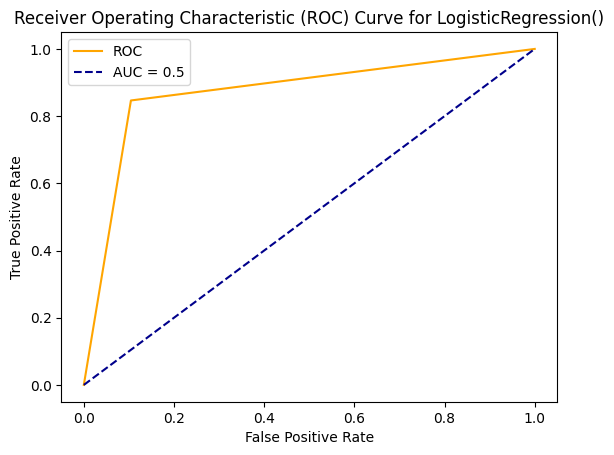

In [9]:
#obter y_pred
y_pred=grid_search.predict(X_test)

#obter fpr,tpr
fpr,tpr,thresholds=roc_curve(y_test,y_pred)

#desenhar curva roc
plot_roc_curve(fpr,tpr,grid_search.estimator[1])

### Support Vector Machine

In [10]:
svm_clf_mms = Pipeline(
    steps=[("preprocessor", preprocessor_mms), ("classifier", LinearSVC())]
)

param_grid = {
    "classifier__C": [0.1, 1.0, 10, 100],
    "classifier__penalty":["l1", "l2"],
    "classifier__loss" : ["hinge","squared_hinge"]
}

grid_search = GridSearchCV(svm_clf_mms, param_grid, cv=10,n_jobs=5,verbose=3)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323760>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F3236D0>)])),
                                       ('classifier', LinearSVC())]),
             n_jobs=5,
             param_grid={'classifier__C': [0.1, 1.0, 10, 100],
                         'classifier__loss': ['hinge', 'squared_hinge'],
                         'classifier__penalty': ['l1', 'l2']},
             verbose=3)

In [11]:
grid_search.best_params_

{'classifier__C': 10, 'classifier__loss': 'hinge', 'classifier__penalty': 'l2'}

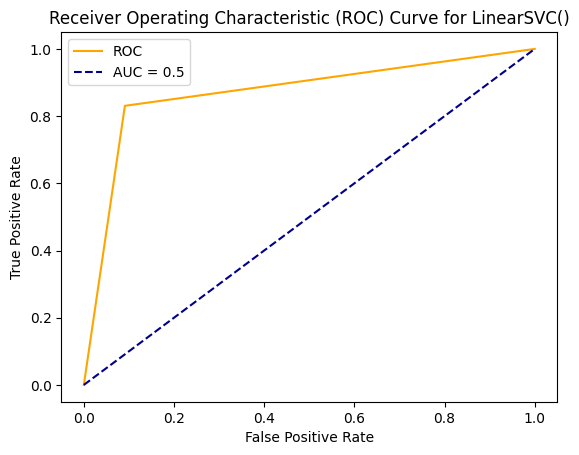

In [12]:
#obter y_pred
y_pred=grid_search.predict(X_test)

#obter fpr,tpr
fpr,tpr,thresholds=roc_curve(y_test,y_pred)

#desenhar curva roc
plot_roc_curve(fpr,tpr,grid_search.estimator[1])

### K-Nearest Neighbor

#### knn com StandardScaler

In [13]:
knn_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())]
)

param_grid = {
    "classifier__weights": ["uniform","distance"],
    "classifier__n_neighbors":list(range(1, 40)),
    "classifier__leaf_size": [10,20,30,40,50]
}

grid_search = GridSearchCV(knn_clf, param_grid, cv=10,n_jobs=5,verbose=3)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 390 candidates, totalling 3900 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323700>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323670>)])),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=5,
             param_grid={'classifier__leaf_size': [10, 20, 30, 40, 50],
                         'classifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                     10, 11, 12, 13, 14, 15, 16,
                                                     17, 18, 19, 20, 21, 22, 23,
                                                     24, 25, 26, 27, 28, 29, 30, ...],
                         'classifier__weights': ['uniform', 'distance']},
             verbose=3)

In [14]:
grid_search.best_params_

{'classifier__leaf_size': 10,
 'classifier__n_neighbors': 11,
 'classifier__weights': 'distance'}

In [15]:
y_pred = grid_search.predict(X_test)

precision = precision_score( y_test, y_pred).round(2)
accuracy = accuracy_score( y_test, y_pred).round(2)
recall = recall_score( y_test, y_pred).round(2)
f1 = f1_score( y_test, y_pred).round(2)

print('Model used: ', grid_search.estimator[1])
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall Score: ', recall)
print('F1-Score: ', f1)


results_plt["KNN_ss"] = {
    "precision": precision,
    "accuracy": accuracy,
    "f1": f1,
    "recall": recall,
}

Model used:  KNeighborsClassifier()
Accuracy:  0.91
Precision:  0.92
Recall Score:  0.87
F1-Score:  0.89


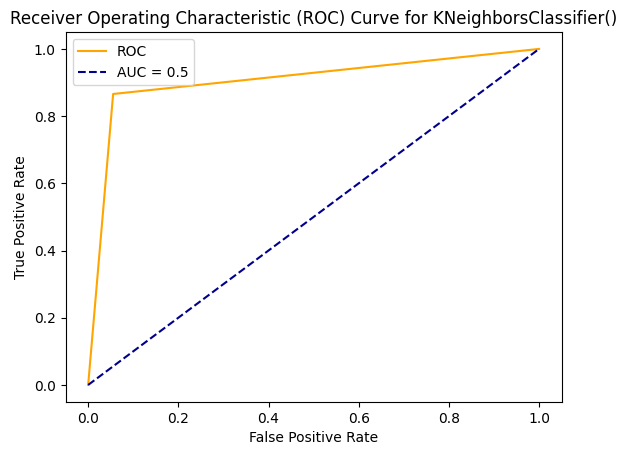

In [16]:
#obter y_pred
y_pred=grid_search.predict(X_test)

#obter fpr,tpr
fpr,tpr,thresholds=roc_curve(y_test,y_pred)

#desenhar curva roc
plot_roc_curve(fpr,tpr,grid_search.estimator[1])

#### knn com min_max_scaler

In [17]:
knn_clf_mms = Pipeline(
    steps=[("preprocessor", preprocessor_mms), ("classifier", KNeighborsClassifier())]
)

param_grid = {
    "classifier__weights": ["uniform","distance"],
    "classifier__n_neighbors":list(range(1, 40)),
    "classifier__leaf_size": [10,20,30,40,50]
}

grid_search = GridSearchCV(knn_clf_mms, param_grid, cv=10,n_jobs=5,verbose=3) # n_jobs=5,verbose=3
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 390 candidates, totalling 3900 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323760>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F3236D0>)])),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=5,
             param_grid={'classifier__leaf_size': [10, 20, 30, 40, 50],
                         'classifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                     10, 11, 12, 13, 14, 15, 16,
                                                     17, 18, 19, 20, 21, 22, 23,
                                                     24, 25, 26, 27, 28, 29, 30, ...],
                         'classifier__weights': ['uniform', 'distance']},
             verbose=3)

In [18]:
grid_search.best_params_

{'classifier__leaf_size': 10,
 'classifier__n_neighbors': 4,
 'classifier__weights': 'distance'}

In [19]:
y_pred = grid_search.predict(X_test)

precision = precision_score( y_test, y_pred).round(2)
accuracy = accuracy_score( y_test, y_pred).round(2)
recall = recall_score( y_test, y_pred).round(2)
f1 = f1_score( y_test, y_pred).round(2)

print('Model used: ', grid_search.estimator[1])
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall Score: ', recall)
print('F1-Score: ', f1)


Model used:  KNeighborsClassifier()
Accuracy:  0.91
Precision:  0.93
Recall Score:  0.86
F1-Score:  0.89


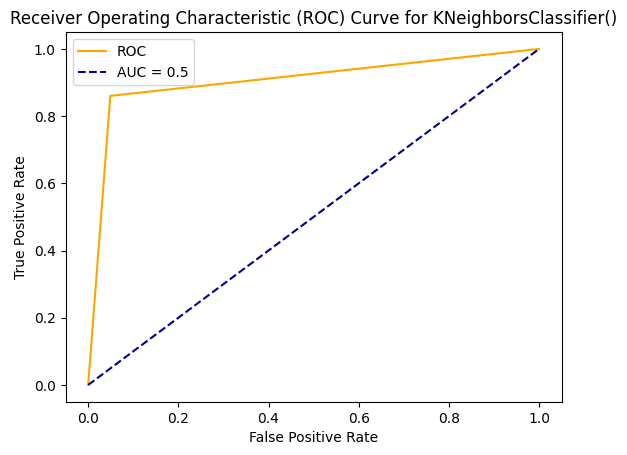

In [20]:
#obter y_pred
y_pred=grid_search.predict(X_test)

#obter fpr,tpr
fpr,tpr,thresholds=roc_curve(y_test,y_pred)

#desenhar curva roc
plot_roc_curve(fpr,tpr,grid_search.estimator[1])

### Decision Trees

In [21]:
dt_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier())]
)

param_grid = {
    "classifier__criterion": ["gini", "entropy"],
    "classifier__max_depth":list(range(1, 10)),
    "classifier__max_features": ["sqrt", "log2", "auto", 22] # sem o 22 dava 89%
}

grid_search = GridSearchCV(dt_clf, param_grid, cv=10, n_jobs=5,verbose=3)
gsf = grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


In [22]:
grid_search.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 9,
 'classifier__max_features': 22}

In [23]:
#adicionar ao dicionário do pré-processamento para comparar com todos os modelos

y_pred=grid_search.predict(X_test)

precision = precision_score( y_test, y_pred).round(2)
accuracy = accuracy_score( y_test, y_pred).round(2)
recall = recall_score( y_test, y_pred).round(2)
f1 = f1_score( y_test, y_pred).round(2)

results_preproc_plt[grid_search.estimator[1]] = {
    "precision": precision,
    "accuracy": accuracy,
    "f1": f1,
    "recall": recall,
}

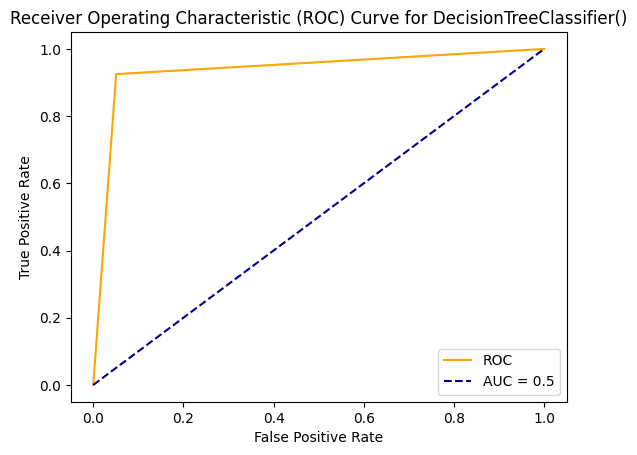

In [24]:
#obter y_pred
y_pred=grid_search.predict(X_test)

#obter fpr,tpr
fpr,tpr,thresholds=roc_curve(y_test,y_pred)

#desenhar curva roc
plot_roc_curve(fpr,tpr,grid_search.estimator[1])

### Naive Bayes

In [25]:
# Multionomial

nb_pre_clf = Pipeline(
    steps=[("preprocessor", preprocessor),("pre_classifier", KBinsDiscretizer())]
)

param_grid = {
    "pre_classifier__n_bins": list(range(2, 10)),
    "pre_classifier__encode":["onehot", "onehot-dense", "ordinal"],
    "pre_classifier__strategy": ["uniform", "quantile", "kmeans"] 
}

grid_search = GridSearchCV(nb_pre_clf, param_grid, cv=10, n_jobs=5,verbose=3,scoring="recall")
grid_search.fit(X_train)
Xt_train = grid_search.transform(X_train)
Xt_test = grid_search.transform(X_test)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


In [26]:
grid_search.best_params_

{'pre_classifier__encode': 'onehot',
 'pre_classifier__n_bins': 2,
 'pre_classifier__strategy': 'uniform'}

In [27]:
nb_clf = Pipeline(
    steps=[("classifier", MultinomialNB())]
)

param_grid = {
    "classifier__alpha":list(range(0,40)),
    "classifier__fit_prior":[True,False]
}

grid_search = GridSearchCV(nb_clf, param_grid, cv=10, n_jobs=5,verbose=3,scoring="recall")
grid_search.fit(Xt_train,y_train)
# Xt_train = grid_search.transform(X_train)
# Xt_test = grid_search.transform(X_train)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


GridSearchCV(cv=10, estimator=Pipeline(steps=[('classifier', MultinomialNB())]),
             n_jobs=5,
             param_grid={'classifier__alpha': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29, ...],
                         'classifier__fit_prior': [True, False]},
             scoring='recall', verbose=3)

In [28]:
grid_search.best_params_

{'classifier__alpha': 39, 'classifier__fit_prior': False}

In [29]:
y_pred = grid_search.predict(Xt_test)

precision = precision_score( y_test, y_pred).round(2)
accuracy = accuracy_score( y_test, y_pred).round(2)
recall = recall_score( y_test, y_pred).round(2)
f1 = f1_score( y_test, y_pred).round(2)

print('Model used: ', grid_search.estimator[0])
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall Score: ', recall)
print('F1-Score: ', f1)

Model used:  MultinomialNB()
Accuracy:  0.82
Precision:  0.78
Recall Score:  0.82
F1-Score:  0.8


In [30]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor)]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = clf.fit_transform(X_train)
X_test = clf.fit_transform(X_test)

# Gaussian to-do

gNB = GaussianNB()
gNB.fit(X_train,y_train)
y_pred = gNB.predict(X_test)

In [31]:
precision = precision_score( y_test, y_pred).round(2)
accuracy = accuracy_score( y_test, y_pred).round(2)
recall = recall_score( y_test, y_pred).round(2)
f1 = f1_score( y_test, y_pred).round(2)

print('Model used: ', gNB)
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall Score: ', recall)
print('F1-Score: ', f1)

Model used:  GaussianNB()
Accuracy:  0.84
Precision:  0.81
Recall Score:  0.82
F1-Score:  0.82


### Random Forest

In [32]:
# novo split test por causa do GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [33]:
rf_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

param_grid = {
    "classifier__criterion": ["gini", "entropy"],
    "classifier__n_estimators":[100,120,140], 
    "classifier__max_depth": [30,50],
    "classifier__min_samples_split": [2,3,4,5],
    "classifier__min_samples_leaf": [2,3,4,5],
    "classifier__bootstrap": [True,False],
    "classifier__class_weight": [{0:1,1:1},{0:1,1:5},{0:1,1:3},"balanced"],
}

grid_search = GridSearchCV(rf_clf, param_grid, cv=5, n_jobs=5,verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323700>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323670>)])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__class_weight': [{0: 1, 1: 1},
                                                      {0: 1, 1: 5},
                                                      {0: 1, 1: 3},
                                                      'balanced'],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [30, 50],
                         'classifier__min_samples_leaf': [2, 3, 4, 5],
                         'classifier__min_samples_split': [2, 3, 4, 5],
                         'classifier__n_estimators': [100, 120, 140]},
             verbose=3)

In [34]:
grid_search.best_params_

{'classifier__bootstrap': False,
 'classifier__class_weight': {0: 1, 1: 1},
 'classifier__criterion': 'gini',
 'classifier__max_depth': 50,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 140}

In [35]:
#adicionar ao dicionário do pré-processamento para comparar com todos os modelos

y_pred=grid_search.predict(X_test)

precision = precision_score( y_test, y_pred).round(2)
accuracy = accuracy_score( y_test, y_pred).round(2)
recall = recall_score( y_test, y_pred).round(2)
f1 = f1_score( y_test, y_pred).round(2)

results_preproc_plt[grid_search.estimator[1]] = {
    "precision": precision,
    "accuracy": accuracy,
    "f1": f1,
    "recall": recall,
}

### ANN

In [36]:
mlp_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", MLPClassifier())]
)

param_grid = {
    "classifier__hidden_layer_sizes": [50,100,150],
    "classifier__activation":["logistic", "tanh", "relu"],
    "classifier__solver":["lbfgs", "sgd", "adam"],
    "classifier__learning_rate": ["constant", "adaptive"],
    "classifier__max_iter": [200,500,1000],
 
}

grid_search = GridSearchCV(mlp_clf, param_grid, cv=4, n_jobs=5,verbose=3)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 162 candidates, totalling 648 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323700>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323670>)])),
                                       ('classifier', MLPClassifier())]),
             n_jobs=5,
             param_grid={'classifier__activation': ['logistic', 'tanh', 'relu'],
                         'classifier__hidden_layer_sizes': [50, 100, 150],
                         'classifier__learning_rate': ['constant', 'adaptive'],
                         'classifier__max_iter': [200, 500, 1000],
                         'classifier__solver': ['lbfgs', 'sgd', 'adam']},
             verbose=3)

In [37]:
#adicionar ao dicionário do pré-processamento para comparar com todos os modelos

y_pred=grid_search.predict(X_test)

precision = precision_score( y_test, y_pred).round(2)
accuracy = accuracy_score( y_test, y_pred).round(2)
recall = recall_score( y_test, y_pred).round(2)
f1 = f1_score( y_test, y_pred).round(2)

results_preproc_plt[grid_search.estimator[1]] = {
    "precision": precision,
    "accuracy": accuracy,
    "f1": f1,
    "recall": recall,
}

In [38]:
grid_search.best_params_

{'classifier__activation': 'logistic',
 'classifier__hidden_layer_sizes': 50,
 'classifier__learning_rate': 'adaptive',
 'classifier__max_iter': 500,
 'classifier__solver': 'adam'}

# Voting Ensemble

In [39]:
# Instanciar modelos com hiperparamteros obtidos anteriormente


lr_clf = LogisticRegression(C=10.0 , penalty='l1',solver='saga')

svc_clf = LinearSVC(C=10, loss='hinge', penalty='l2')

dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=9, max_features=22)

gNB_clf = GaussianNB()

rf_clf = RandomForestClassifier(bootstrap=False, criterion='gini',
                                class_weight = {0: 1, 1: 1},
                                max_depth=50,min_samples_leaf=2,
                                min_samples_split=5, n_estimators=120)

mlp_clf = MLPClassifier(activation='logistic' , hidden_layer_sizes=150, learning_rate='adaptive',
                       max_iter=500, solver='adam')


In [40]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor)]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = clf.transform(X_train)
X_test = clf.transform(X_test)

In [41]:
voting_clf = VotingClassifier(
    estimators=[
            ('lr', lr_clf), 
            ('svc', svc_clf),
            ('dt', dt_clf),
            ('gnb',gNB_clf),
            ('rf', rf_clf),
            ('mlp', mlp_clf),
    ], 
    voting='hard')

In [42]:
# Guardar resultados no dicionário

from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

for clf in (lr_clf, svc_clf, dt_clf,gNB_clf,rf_clf,mlp_clf,voting_clf):
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    
    precision = precision_score( y_test, y_pred).round(2)
    accuracy = accuracy_score( y_test, y_pred).round(2)
    recall = recall_score( y_test, y_pred).round(2)
    f1 = f1_score( y_test, y_pred).round(2)
    
    results_plt[clf.__class__.__name__] = {
        "precision": precision,
        "accuracy": accuracy,
        "f1": f1,
        "recall": recall,
    }
    
    print('*********')
    
    


*********
*********
*********
*********
*********
*********
*********


In [194]:
results_plt

{'KNN_ss': {'precision': 0.92, 'accuracy': 0.91, 'f1': 0.89, 'recall': 0.87},
 'LogisticRegression': {'precision': 0.86,
  'accuracy': 0.87,
  'f1': 0.86,
  'recall': 0.85},
 'LinearSVC': {'precision': 0.88,
  'accuracy': 0.88,
  'f1': 0.86,
  'recall': 0.84},
 'DecisionTreeClassifier': {'precision': 0.93,
  'accuracy': 0.93,
  'f1': 0.92,
  'recall': 0.92},
 'GaussianNB': {'precision': 0.81,
  'accuracy': 0.84,
  'f1': 0.82,
  'recall': 0.83},
 'RandomForestClassifier': {'precision': 0.95,
  'accuracy': 0.96,
  'f1': 0.95,
  'recall': 0.95},
 'MLPClassifier': {'precision': 0.94,
  'accuracy': 0.95,
  'f1': 0.94,
  'recall': 0.94},
 'VotingClassifier': {'precision': 0.95,
  'accuracy': 0.92,
  'f1': 0.91,
  'recall': 0.87}}

# Unsupervised Learning as preprocessing

In [43]:
results_preproc_plt = {}

### Clustering + Logistic Regression

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [45]:
kmlr_clf = Pipeline(
    steps=[("preprocessor",preprocessor),
           ("kmeans", KMeans()), 
           ("classifier", LogisticRegression())]
)

param_grid = {
        "kmeans__n_clusters": [int(x) for x in np.linspace(2,200,30)],
        "kmeans__algorithm": ["lloyd", "elkan", "auto", "full"]
}

grid_search = GridSearchCV(kmlr_clf, param_grid, cv=4, n_jobs=5,verbose=3)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323700>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323670>)])),
                                       ('kmeans', KMeans()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=5,
             param_grid={'kmeans__algorithm': ['lloyd', 'elkan', 'auto',
                                               'full'],
                         'kmeans__n_clusters': [2, 8, 15, 22, 29, 36, 42, 49,
                                                56, 63, 70, 77, 83, 90, 97, 104,
                                                111, 118, 124, 131, 138, 145,
                                                152, 159, 165, 172, 179, 186,
                                                193, 200]},
             verbose=3)

In [46]:
grid_search.best_params_

{'kmeans__algorithm': 'auto', 'kmeans__n_clusters': 179}

In [47]:
y_pred = grid_search.predict(X_test)


# print('Model used for preprocessing the data: ', grid_search.estimator[1], '\n')
# print('Model used: ', grid_search.estimator[2], '\n')
# print('Accuracy: ', accuracy_score( y_test, y_pred).round(2))
# print('Precision: ', precision_score( y_test, y_pred).round(2))
# print('Recall Score: ', recall_score( y_test, y_pred).round(2))
# print('F1-Score: ', f1_score( y_test, y_pred).round(2))
    
precision = precision_score( y_test, y_pred).round(2)
accuracy = accuracy_score( y_test, y_pred).round(2)
recall = recall_score( y_test, y_pred).round(2)
f1 = f1_score( y_test, y_pred).round(2)

results_preproc_plt["KMeans + LR"] = {
    "precision": precision,
    "accuracy": accuracy,
    "f1": f1,
    "recall": recall,
}

### Clustering + SVC

In [48]:
kmsvc_clf = Pipeline(
    steps=[("preprocessor",preprocessor_mms),
           ("kmeans", KMeans()), 
           ("classifier", LinearSVC())]
)

param_grid = {
        "kmeans__n_clusters": [int(x) for x in np.linspace(2,200,30)],
        "kmeans__algorithm": ["lloyd", "elkan", "auto", "full"],
}

grid_search = GridSearchCV(kmsvc_clf, param_grid, cv=4, n_jobs=5,verbose=3)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323760>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F3236D0>)])),
                                       ('kmeans', KMeans()),
                                       ('classifier', LinearSVC())]),
             n_jobs=5,
             param_grid={'kmeans__algorithm': ['lloyd', 'elkan', 'auto',
                                               'full'],
                         'kmeans__n_clusters': [2, 8, 15, 22, 29, 36, 42, 49,
                                                56, 63, 70, 77, 83, 90, 97, 104,
                                                111, 118, 124, 131, 138, 145,
                                                152, 159, 165, 172, 179, 186,
                                                193, 200]},
             verbose=3)

In [49]:
grid_search.best_params_

{'kmeans__algorithm': 'elkan', 'kmeans__n_clusters': 186}

In [50]:
y_pred = grid_search.predict(X_test)
    
precision = precision_score( y_test, y_pred).round(2)
accuracy = accuracy_score( y_test, y_pred).round(2)
recall = recall_score( y_test, y_pred).round(2)
f1 = f1_score( y_test, y_pred).round(2)

results_preproc_plt["KMeans + SVM"] = {
    "precision": precision,
    "accuracy": accuracy,
    "f1": f1,
    "recall": recall,
}

### Clustering + kneighbors

In [51]:
kmkn_clf = Pipeline(
    steps=[("preprocessor",preprocessor),
           ("kmeans", KMeans()), 
           ("classifier",KNeighborsClassifier())]
)

param_grid = {
        "kmeans__n_clusters": [int(x) for x in np.linspace(2,200,30)],
        "kmeans__algorithm": ["lloyd", "elkan", "auto", "full"],
}

grid_search = GridSearchCV(kmkn_clf, param_grid, cv=4, n_jobs=5,verbose=3)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323700>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323670>)])),
                                       ('kmeans', KMeans()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=5,
             param_grid={'kmeans__algorithm': ['lloyd', 'elkan', 'auto',
                                               'full'],
                         'kmeans__n_clusters': [2, 8, 15, 22, 29, 36, 42, 49,
                                                56, 63, 70, 77, 83, 90, 97, 104,
                                                111, 118, 124, 131, 138, 145,
                                                152, 159, 165, 172, 179, 186,
                                                193, 200]},
             verbose=3)

In [52]:
grid_search.best_params_

{'kmeans__algorithm': 'auto', 'kmeans__n_clusters': 193}

In [53]:
y_pred = grid_search.predict(X_test)

    
precision = precision_score( y_test, y_pred).round(2)
accuracy = accuracy_score( y_test, y_pred).round(2)
recall = recall_score( y_test, y_pred).round(2)
f1 = f1_score( y_test, y_pred).round(2)

results_preproc_plt["KMeans + Kneighbors"] = {
    "precision": precision,
    "accuracy": accuracy,
    "f1": f1,
    "recall": recall,
}

### Clustering + GaussianNB

In [54]:
kmgnb_clf = Pipeline(
    steps=[("preprocessor",preprocessor),
           ("kmeans", KMeans()), 
           ("classifier",GaussianNB())]
)

param_grid = {
        "kmeans__n_clusters": [int(x) for x in np.linspace(2,200,30)],
        "kmeans__algorithm": ["lloyd", "elkan", "auto", "full"],
}

grid_search = GridSearchCV(kmgnb_clf, param_grid, cv=4, n_jobs=5,verbose=3)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323700>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002805F323670>)])),
                                       ('kmeans', KMeans()),
                                       ('classifier', GaussianNB())]),
             n_jobs=5,
             param_grid={'kmeans__algorithm': ['lloyd', 'elkan', 'auto',
                                               'full'],
                         'kmeans__n_clusters': [2, 8, 15, 22, 29, 36, 42, 49,
                                                56, 63, 70, 77, 83, 90, 97, 104,
                                                111, 118, 124, 131, 138, 145,
                                                152, 159, 165, 172, 179, 186,
                                                193, 200]},
             verbose=3)

In [55]:
grid_search.best_params_

{'kmeans__algorithm': 'auto', 'kmeans__n_clusters': 90}

In [56]:
y_pred = grid_search.predict(X_test)
    
precision = precision_score( y_test, y_pred).round(2)
accuracy = accuracy_score( y_test, y_pred).round(2)
recall = recall_score( y_test, y_pred).round(2)
f1 = f1_score( y_test, y_pred).round(2)

results_preproc_plt["KMeans + GaussianNB"] = {
    "precision": precision,
    "accuracy": accuracy,
    "f1": f1,
    "recall": recall,
}

# Plots

In [57]:
def plot_results(results , figsize = None):
    # Get the names of the models
    model_names = list(results.keys())

    # Get the metrics for each model
    precision = [results[name]["precision"] for name in model_names]
    accuracy = [results[name]["accuracy"] for name in model_names]
    f1 = [results[name]["f1"] for name in model_names]
    recall = [results[name]["recall"] for name in model_names]


    # Set up the plot
    #fig, ax = plt.subplots(figsize=(14,12))
    fig, ax = plt.subplots(figsize=figsize)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9)
    index = np.arange(len(model_names))
    bar_width = 0.15
    bar_gap = 0.03
    opacity = 0.8

    # Plot the precision, accuracy, f1, and recall values
    rects1 = plt.bar(index, precision, bar_width,
                   alpha=opacity,
                   color='b',
                   label='Precision')
    rects2 = plt.bar(index + bar_width + bar_gap, accuracy, bar_width,
                   alpha=opacity,
                   color='g',
                   label='Accuracy')
    rects3 = plt.bar(index + 2* (bar_width + bar_gap), f1, bar_width,
                   alpha=opacity,
                   color='r',
                   label='F1')
    rects4 = plt.bar(index + 3* (bar_width + bar_gap), recall, bar_width,
                   alpha=opacity,
                   color='c',
                   label='Recall')
    
    plt.axhline(y=0.9, color='black', linestyle='--', linewidth=2)
    
    plt.text(x=0, y=0.9, s='threshold value', verticalalignment='center', horizontalalignment='right', transform=ax.transAxes)

    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Evaluation Metrics')
    plt.xticks(index + bar_width, model_names,  rotation=-45)
    plt.legend()

    plt.tight_layout()
    plt.show()

# SL plots

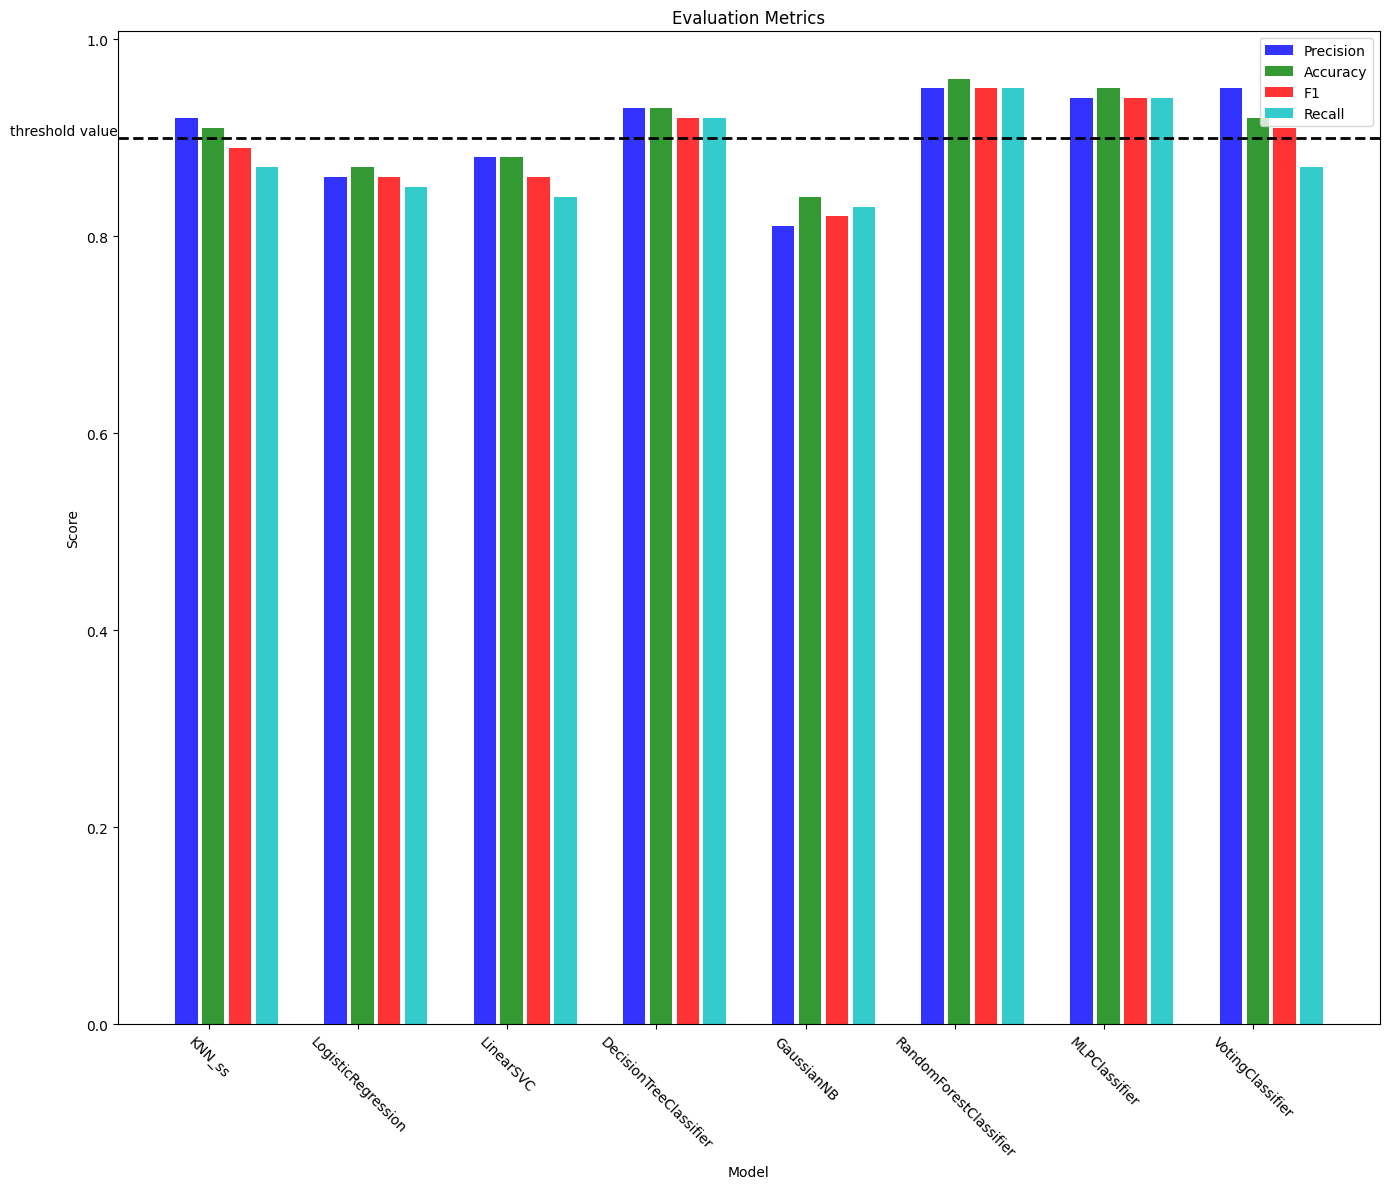

In [58]:
plot_results(results_plt , (14,12))

# UL as preprocessing plots

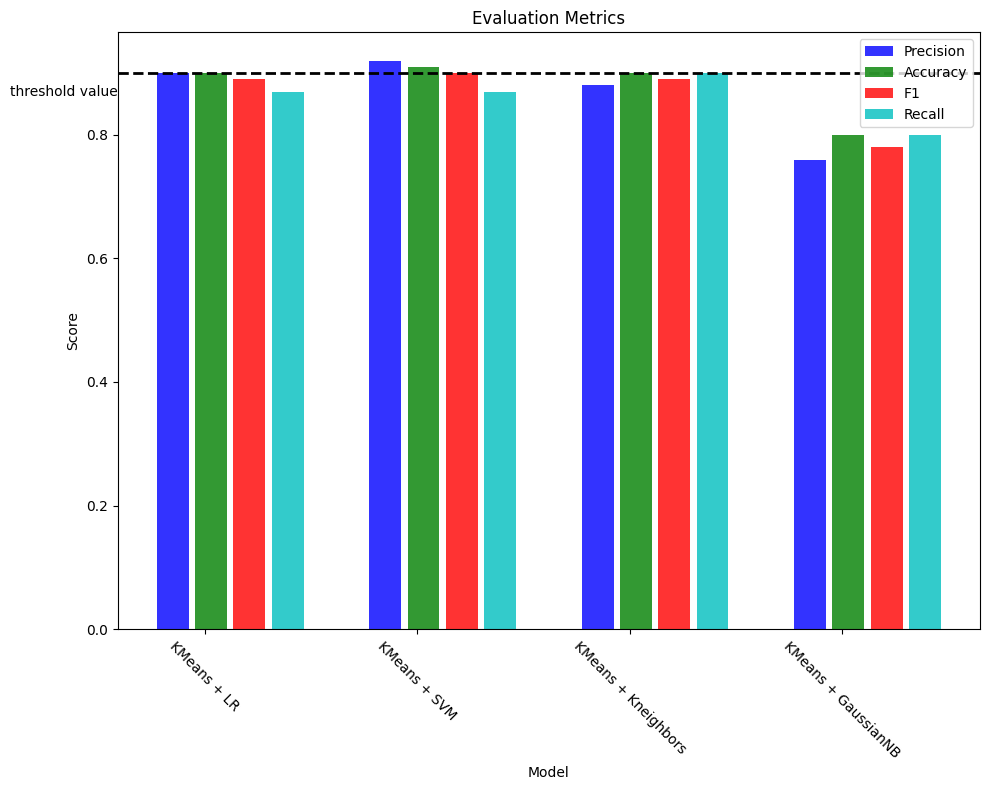

In [59]:
plot_results(results_preproc_plt, (10,8))

# Unsupervised Learning

In [131]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

# Function used to train and evaluate the models (includes GridSearch and RandomizedSearch)
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_precision_recall_curve

# unsupervised metrics
from sklearn.metrics import silhouette_score 
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score, completeness_score

# Model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [123]:
# KMeans and Birch pre-processing functions
from sklearn.cluster import KMeans, Birch, DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

In [157]:
# Takes the model function and the params (to use GridSearch)
def trainModel(model, params=False, randomized=True, supervised=True):

    if params: 
        gs = GridSearchCV(
            model,
            params,
            verbose = 1,
            cv = 6,
            scoring='recall'
        )
        
        gs_res = gs.fit(X_train, y_train)
        print(gs_res.best_score_)
        # print(gs_results.best_estimator_)
        print(gs_res.best_params_)

        if randomized: 
            rs = RandomizedSearchCV(
                model, 
                params,
                verbose = 1,
                cv=6,
                random_state=42, 
                scoring='recall'
            )

            rs_res = rs.fit(X_train,y_train)
            print(rs_res.best_score_)
            # print(rs_results.best_estimator_)
            print(rs_res.best_params_)
    
        if randomized: 
            usedModel = rs_res.best_estimator_ if rs_res.best_score_ > gs_res.best_score_ else gs_res.best_estimator_
        else:
            usedModel = gs_res.best_estimator_
    else:
        usedModel = model

    usedModel.fit(X_train, y_train)
    y_pred = usedModel.predict(X_test)

    # Confusion matrix and getting the displayed values
    if supervised:
        disp_confusion_matrix = plot_confusion_matrix(usedModel,X_test, y_test, cmap=plt.cm.Blues)
        plt.show()

    # AUC and ROC curve plot function
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

    def plot_roc_curve(fpr, tpr,label=None):
        plt.plot(fpr, tpr,label=label)
        plt.plot([0,1],[0,1],'r--')
        plt.xlabel('False Negative Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')

    if supervised:
        plot_roc_curve(fpr,tpr)

    # Cross validation
    cross_validation = cross_val_score(usedModel,X_train,y_train,scoring="recall", cv=10)
    
    # Precision Recall curve to get the most of both metrics
    # disp = plot_precision_recall_curve(usedModel, X_test, y_test)
    # disp.ax_.set_title('2-class Precision-Recall curve: ', precision)

    auxObj = {
        'Accuracy': [accuracy_score(y_test, y_pred).round(3)],
        'Precision': [precision_score(y_test, y_pred,average='micro').round(3)],
        'Recall': [recall_score(y_test, y_pred,average='micro').round(3)],
        'F1': [f1_score(y_test, y_pred,average='micro').round(3)],
        'Cross Validation': [np.mean(cross_validation).round(3)]
    }
    
    if supervised:
        auxObj['Train Score'] = [usedModel.score(X_train, y_train).round(3)]
        auxObj['AUC'] = [auc(fpr, tpr).round(3)]
    else:
        groups = usedModel.labels_
        auxObj['Silhouette'] = silhouette_score(X_train, groups)
        auxObj['Homogeneity'] = homogeneity_score(y_train, groups)
        auxObj['Completeness'] = completeness_score(y_train, groups)
        auxObj['ARI'] = adjusted_rand_score(y_train, groups)
        auxObj['NMI'] = normalized_mutual_info_score(y_train, groups)


    return pd.DataFrame(auxObj)

In [172]:
# BIRCH isolado
birch=Birch(n_clusters=3)

trainModel(birch, False, True, False)

,Accuracy,Precision,Recall,F1,Cross Validation,Silhouette,Homogeneity,Completeness,ARI,NMI
0,0.555,0.555,0.555,0.555,NaN,0.048834,0.183009,0.128742,0.114498,0.151152


In [187]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(X_train)
X_embedded.shape

(8000, 2)

In [181]:
X=df.drop(['satisfaction'], axis=1)
y=df['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(X_train)
X_embedded.shape

(8000, 2)

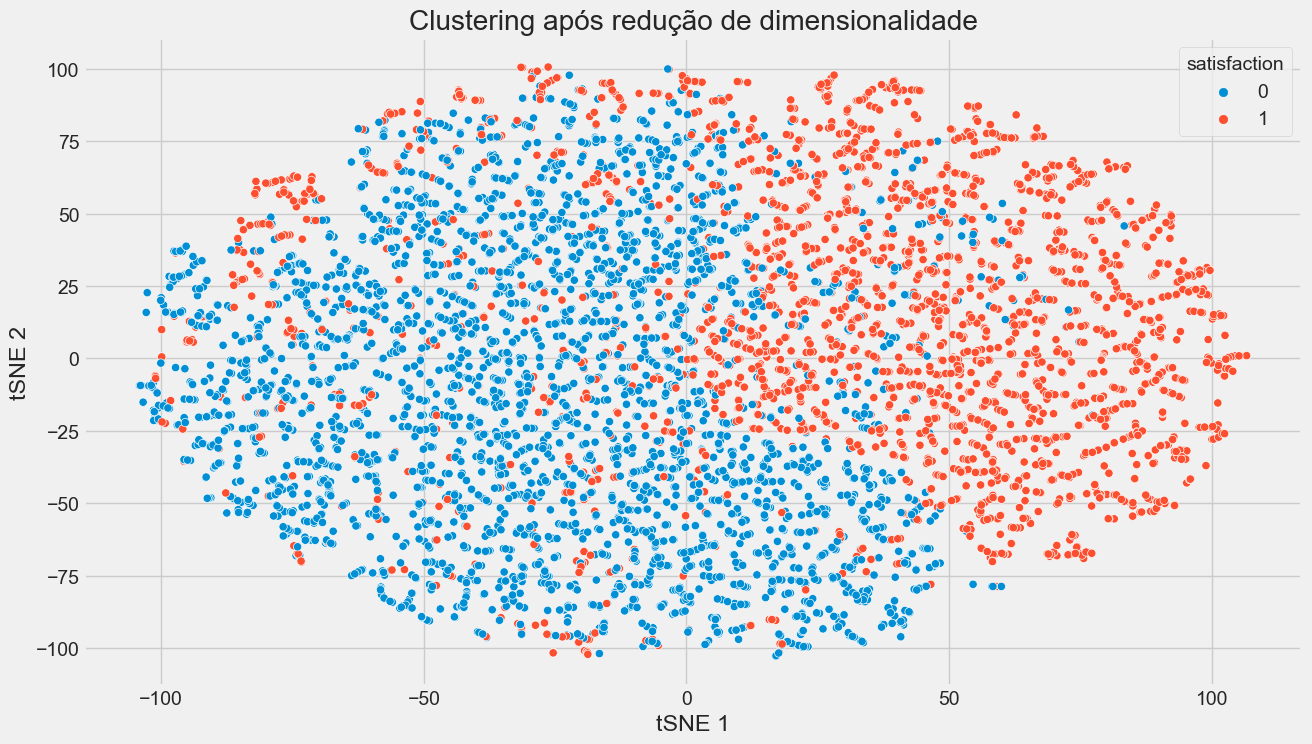

In [188]:
plt.figure(figsize=(14,8))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_train)
plt.title('Clustering após redução de dimensionalidade')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.show()

In [185]:
from sklearn.manifold import TSNE

X_embedded_t = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(X_test)
X_embedded_t.shape

(2000, 2)

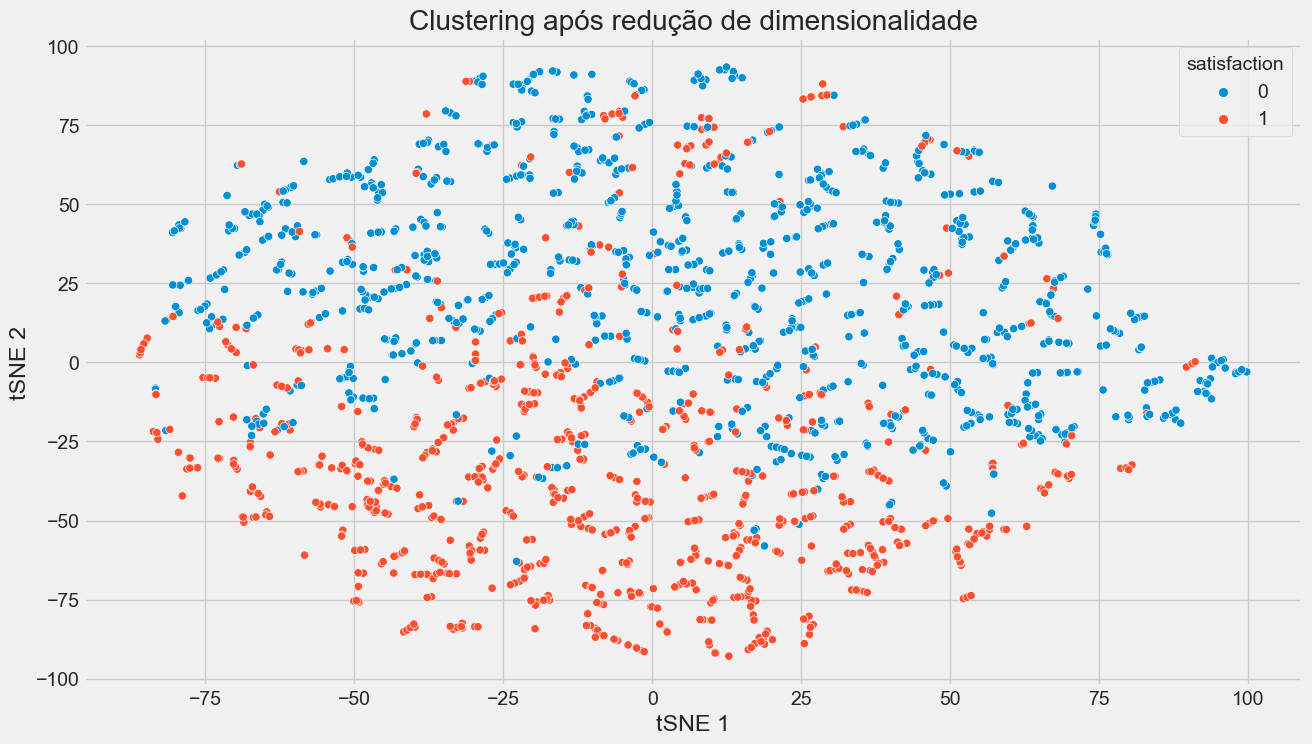

In [186]:
plt.figure(figsize=(14,8))
sns.scatterplot(x=X_embedded_t[:,0], y=X_embedded_t[:,1], hue=y_test)
plt.title('Clustering após redução de dimensionalidade')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.show()